The data set that we utilized for our ICA algorithm was obtained from The University of California Irvine's Machine Learning Repository. It was originally collected by Oliver Roesler who used a 14 channel Emotive Epoc EEG headset to collect a continous 117 seconds of live EEG recording from a human. Video was also taken of the participants blinks while EEG recording was in progress. The database consists of 15 columns of data, the first 14 being vectors of microvolt measurements taken from the 14 different EEG channels (which are labeled in code). A single vector represents the EEG microvolt measurement of a particular channel over time. The 15th column vector was obtained by recording the particpant's blinks and then inputing the state of the participants eye in the column vector. This eye state is labeled with a "0" when the participants eyes were open and a "1" representing a closed eye.

We start are starting our exploration of ICA by running this data through a commonly used ICA algorithm from scikit-learn's toolbox called fastica in order to locate and remove blink data from the eeg channels.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import genfromtxt
from numpy.matlib import repmat
from sklearn.datasets import load_digits
from sklearn.decomposition import FastICA
from sklearn.preprocessing import normalize
from scipy import signal
import seaborn as sns

#read in UCI EEG data rom https://archive.ics.uci.edu/ml/datasets/EEG+Eye+State#
#file EEG EYE STATE.arff then converted to csv
#with https://pulipulichen.github.io/jieba-js/weka/arff2csv/
# Data represents one 117 second measurement of 14 eeg channels from
# the Emotiv EEG Neuroheadset
# the 15th data colomn is the labels of the eye state. With o representing an open eye
# and 1 representing a closed eye. 
#"The features correspond to 14 EEG measurements from the headset,
#originally labeled AF3, F7, F3, FC5, T7, P, O1, O2, P8, T8, FC6, F4, F8, AF4, in that order."

#For consistency purposes
np.random.seed(7)

#my_data is a 14980 row 15 column vector np array
my_data = genfromtxt('Dunn2.csv', delimiter=',')

ICA is useful in removing artifact from eeg data, but there are other data cleaning steps that are necassary before running ICA. Two of those steps are outlier removal and drift correction. Upon original observation of the data from each channel, it became clear that there were four extremely large spikes in the data that were present across all eeg channels. Depending on the channel, these spikes were thousands to hundreds of thousands of microvolts above any other spikes in the data. These spikes were so clearly outliers that it was unecasssary to run the 1.5 Iqr test for outliers and these datapoints were removed.There was no drift present in the data, this is likely due to the short window of data collection (117 seconds).

In [3]:
#Because large outlier spikes existed in the data and it was clear that they were not
#part of the neural signals they need to be eliminated eliminate columnss of outlier noise
my_data = np.delete(my_data,np.s_[10384:10388],axis=0)
my_data = np.delete(my_data,np.s_[11505:11508],axis=0)
my_data = np.delete(my_data,np.s_[897:900],axis=0)
my_data = np.delete(my_data,np.s_[13168:13171],axis=0)
my_data.shape

(14967, 15)

In [4]:
#Separate the eye blink data and the EEG channel data
eye_data = my_data[:,14]
my_data = my_data[:,:14]
my_data.shape

(14967, 14)

For exploration purposes, the data all 14 eeg channels were graphed. as was the state of the eye over time.


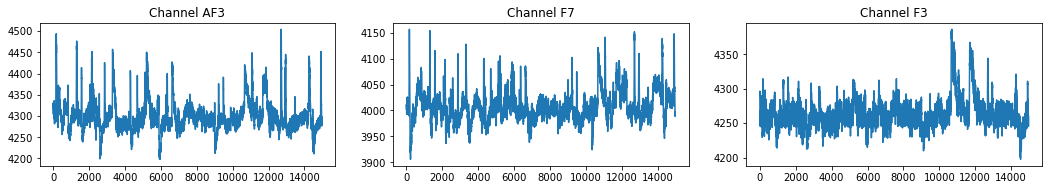

In [5]:
#Plot each individual EEG channel
#Set X as a vector of numerical integer values from 1 to 14980
X = np.arange(0, my_data.shape[0]) 
  
# set yi to be the ith column vector in my_data
Y0,Y1,Y2,Y3,Y4,Y5,Y6,Y7,Y8,Y9,Y10,Y11,Y12,Y13 = tuple([my_data[:,i] for i in range(14)])
Y14 =  eye_data
# Initialise the subplot function using number of rows and columns with adjusted fig size
#set channels sequetially in subplot and graph
figure, axis = plt.subplots(1,3,figsize = (15,3))
  
# Channel AF3
axis[0].plot(X, Y0)
axis[0].set_title("Channel AF3")
  # Channel F7
axis[1].plot(X, Y1)
axis[1].set_title("Channel F7")
  # Channel F3
axis[2].plot(X, Y2)
axis[2].set_title("Channel F3")
  
# Combine all the operations and display with appropriate spacing
plt.tight_layout(pad=2.0)
plt.show()

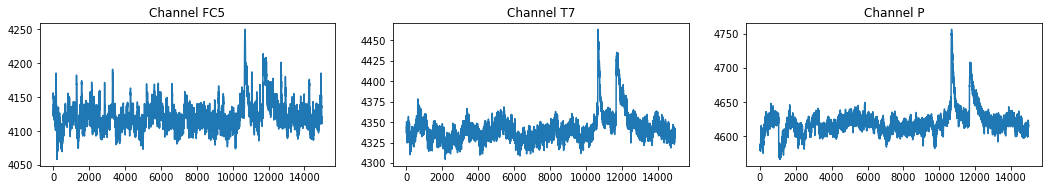

In [6]:
figure, axis = plt.subplots(1,3,figsize = (15,3))
# Channel FC5
axis[0].plot(X, Y3)
axis[0].set_title("Channel FC5")
# Channel T7
axis[1].plot(X, Y4)
axis[1].set_title("Channel T7")
# Channel P
axis[2].plot(X, Y5)
axis[2].set_title("Channel P")
  
# Combine all the operations and display
plt.tight_layout(pad=2.0)
plt.show()

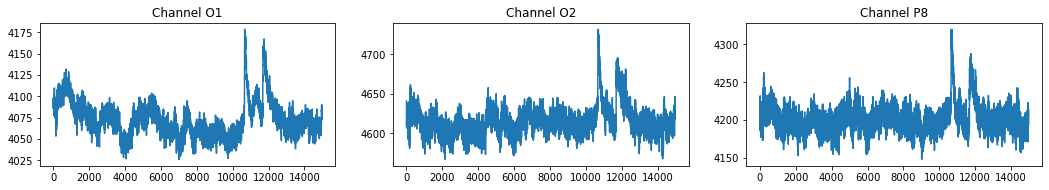

In [7]:
figure, axis = plt.subplots(1,3,figsize = (15,3))

# Channel O1
axis[0].plot(X, Y6)
axis[0].set_title("Channel O1")
# Channel O2
axis[1].plot(X, Y7)
axis[1].set_title("Channel O2")
# Channel P8
axis[2].plot(X, Y8)
axis[2].set_title("Channel P8")
  
# Combine all the operations and display
plt.tight_layout(pad=2.0)
plt.show()

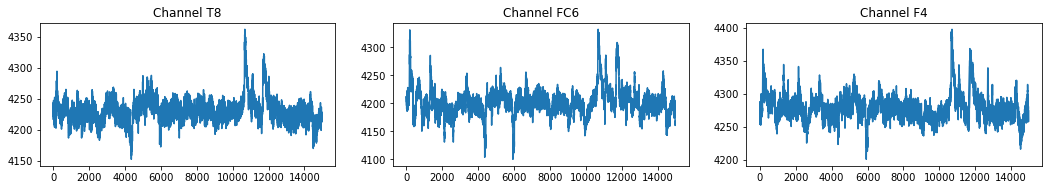

In [8]:
figure, axis = plt.subplots(1,3,figsize = (15,3))
# Channel T8
axis[0].plot(X, Y9)
axis[0].set_title("Channel T8")
# Channel FC6
axis[1].plot(X, Y10)
axis[1].set_title("Channel FC6")
# Channel F4
axis[2].plot(X, Y11)
axis[2].set_title("Channel F4")
  
# Combine all the operations and display
plt.tight_layout(pad=2.0)
plt.show()

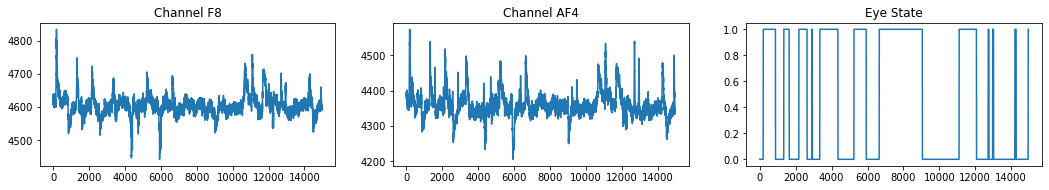

In [9]:
figure, axis = plt.subplots(1,3,figsize = (15,3))
# Channel F8
axis[0].plot(X, Y12)
axis[0].set_title("Channel F8")
# Channel AF4
axis[1].plot(X, Y13)
axis[1].set_title("Channel AF4")
# Eye State (labels)
axis[2].plot(X, Y14)
axis[2].set_title("Eye State")
  
# Combine all the operations and display
plt.tight_layout(pad=2.0)
plt.show()

In [10]:
#Default ICA implementation -- running fastIca from scikitlearn
transformer = FastICA(n_components=10,
whiten='unit-variance')
my_data_transformed = transformer.fit_transform(my_data)
my_data_transformed.shape

(14967, 10)

The following visualization represents all channels before transformation (red), all components obtained from ica (green), and all instances of blinking (blue dashed line). These graphs allow us to visualize which components are leading to the spikes occuring during blinks. We accomplished this by running through each component and visually comparing it to the pre-transformed data, to see which components were responsible for the blink data.

1 



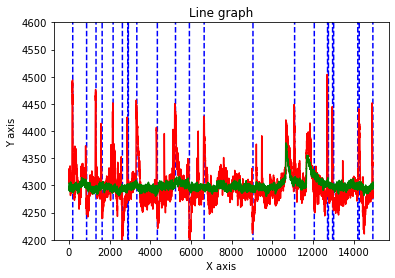

2 



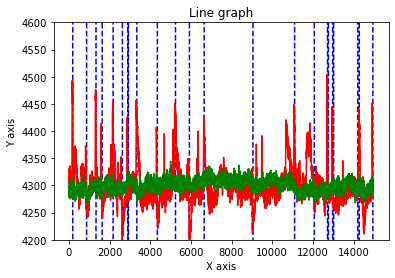

3 



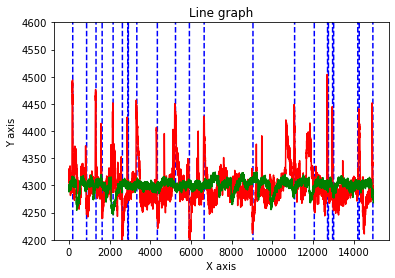

4 



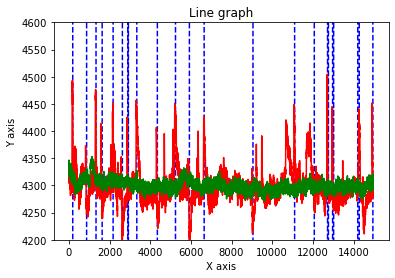

5 



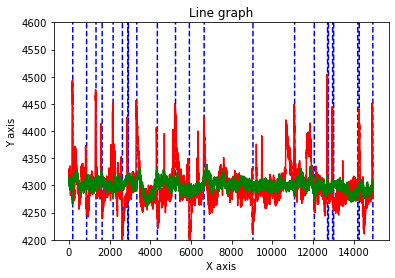

6 



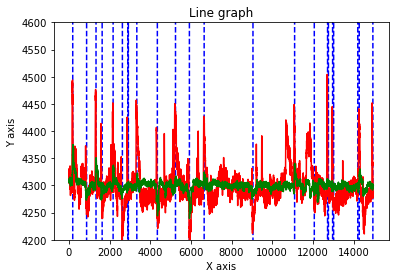

7 



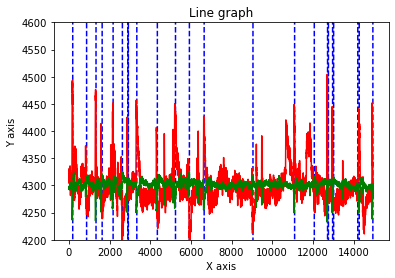

8 



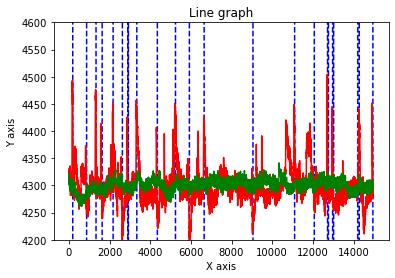

9 



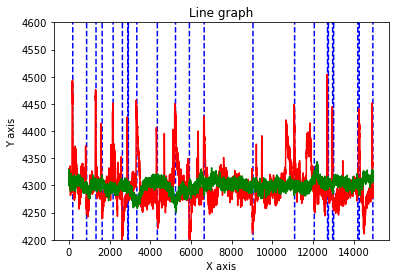

10 



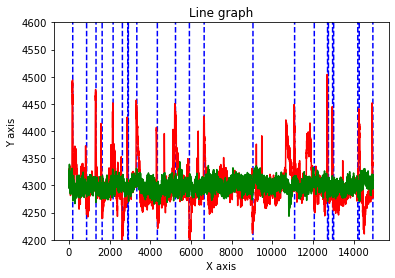

In [11]:
#plot one column vector (channel) and compare to the state column to see when blinks were occuring data to be plotted
#channelAF3 transformed//scaled to line up visually with untransformed data

for i in range(my_data_transformed.shape[1]):
    print((i+1), "\n")
    y = (my_data_transformed[:,i]*1250)+4300
    z = my_data[:,0] #Channel AF3 before FastICA
    b = eye_data*5000 # Eye State column

    #plotting
    plt.title("Line graph")
    plt.xlabel("X axis")
    plt.ylabel("Y axis")
    plt.plot(X,b , color ="blue",linestyle = "dashed")
    plt.ylim(4200,4600)
    plt.plot(X, z, color ="red")
    plt.plot(X, y, color ="green")
    plt.show()

The visualization above represents each channel after our FastICA translation. We believe that channels six and seven represent the blink, as they have peaks that correspond at each blink occurence. After the elimination of the artifact components, the data is reconstructed using scikit-learn's inversetransform method.

In [27]:
#remove blinks by setting component vectors related to blinking to 0
my_data_transformed[:, [5,6]] = 0
my_data_restored = transformer.inverse_transform(my_data_transformed)
my_data_restored.shape

(14967, 14)

The following graphs illustrate both the original and the reconstructed data, which has been stripped of the blink components that were discovered with the ICA tools.

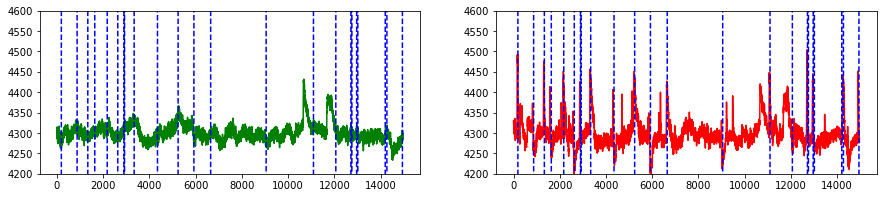

In [13]:
# channel AF3 reconstructed without blink component
figure, axis = plt.subplots(1,2,figsize = (15,3))
axis[0].plot(X,my_data_restored[:,0],color = "green")
axis[0].plot(X,b , color ="blue",linestyle = "dashed")
axis[0].set_ylim(4200,4600)

#original of channel AF3 -- Blink Included
axis[1].plot(X,Y0,color = "red")
axis[1].plot(X, b , color ="blue",linestyle = "dashed")
axis[1].set_ylim(4200,4600)
plt.show()

Next, we have our own custom implementation of Principal Component Analysis. Principal Component Analysis is used to preprocess and decorrelate our data for the next step of Independent Component Analysis.

In [14]:
def eigsort(V, eigvals):
    
    # Sort the eigenvalues from largest to smallest. Store the sorted
    # eigenvalues in the column vector lambd.
    lohival = np.sort(eigvals)
    lohiindex = np.argsort(eigvals)
    lambd = np.flip(lohival)
    index = np.flip(lohiindex)
    Dsort = np.diag(lambd)
    
    # Sort eigenvectors to correspond to the ordered eigenvalues. Store sorted
    # eigenvectors as columns of the matrix vsort.
    M = np.size(lambd)
    Vsort = np.zeros((M, M))
    for i in range(M):
        Vsort[:,i] = V[:,index[i]]
    return Vsort, Dsort

def principle_matrix(data):
    means = np.mean(my_data, axis=1, keepdims = True)

    #zero means and transpose matrix
    zeroed_data = my_data - np.matlib.repmat(means, 1, 14)
    D, V = np.linalg.eig(zeroed_data.transpose()@zeroed_data)
    V, D = eigsort(V, D)

    U = zeroed_data@V
    U = normalize(U, norm='l2', axis=0)
    return U


In [15]:
means = np.mean(my_data, axis=1, keepdims = True)

#zero means and transpose matrix
zeroed_data = my_data - np.matlib.repmat(means, 1, 14)
zeroed_data.shape

(14967, 14)

In [16]:
U = principle_matrix(my_data)
num_principal_components = 3
coords = U.T @ zeroed_data[:,7] 
reconstructed_col = U@np.array((coords[:, np.newaxis]))+means
reconstructed_n_components_col = U[:,:num_principal_components]@np.array((coords[:num_principal_components][:, np.newaxis]))+means

In [17]:
reconstructed = U.T @ zeroed_data[:,:]
reconstructed_for_ica = U[:,:5]@np.array((reconstructed[:5][:]))
reconstructed_for_ica.shape
U.shape

(14967, 14)

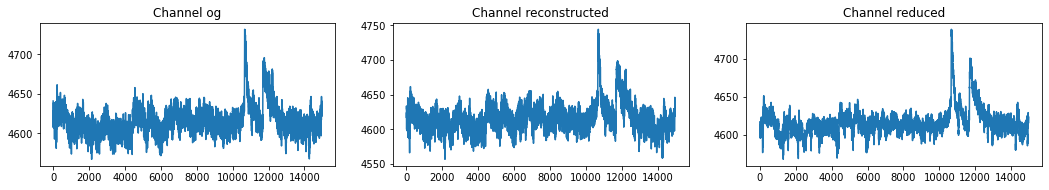

In [18]:
#Set vals
Y7 = my_data[:,7]
Y7rec = reconstructed_col[:,0]
Y7red = reconstructed_n_components_col[:,0]

figure, axis = plt.subplots(1,3,figsize = (15,3))
# Channel T7 original
axis[0].plot(X, Y7)
axis[0].set_title("Channel og")
# Channel T7 reconstructed
axis[1].plot(X, Y7rec)
axis[1].set_title("Channel reconstructed")
# Channel T7 reconstructed w first 10 PC's
axis[2].plot(X, Y7red)
axis[2].set_title("Channel reduced")

# Combine all the operations and display
plt.tight_layout(pad=2.0)
plt.show()

Once we've run Principal Component Analysis, we are able to define and run our Independent Component Analysis. We took this algorithm from an [online source](https://towardsdatascience.com/independent-component-analysis-ica-in-python-a0ef0db0955e 'ICA In Python'), and modified/rewrote it to better suit our purposes. 

In [19]:
def g(x):
    return np.tanh(x)

def g_der(x):
    return 1 - np.tanh(x) ** 2

def recalculate_w(w, X):
    w_new = (X * g(w.T@X)).mean(axis=1) - g_der(w.T@X).mean() * w    
    w_new /= np.sqrt((w_new ** 2).sum())    
    return w_new

In [20]:
def ica(X, iterations, tolerance):
    components_count = X.shape[0]
    #Initialize empty weights matrix
    W = np.zeros((components_count, components_count), dtype=X.dtype) 
    
    #For each number of components we want to see in our output
    for i in range(components_count):
        #initialize a random vector
        w = np.random.rand(components_count)
        j = 0
        converged = False
        #Loop while the ICA algorithm hasn't converged and hasn't reached set iterations. 
        while j < iterations and not converged:
            #Here we recaculate our demixing matrix using the current X data
            w_new = recalculate_w(w, X)
            
            #Normalizing the demixing matrix
            if i >= 1:
                w_new -= (w_new@W[:i].T)@W[:i]
            
            #calculating whether or not we've reached convergence
            distance = np.abs(np.abs((w * w_new).sum()) - 1)
            if distance < tolerance:
                converged = True
                
                
            w = w_new
            j+=1
                
        W[i, :] = w
        
    S = W@X
    
    return S

In [21]:
def plot_results(X, S):
    fig = plt.figure()    
    plt.subplot(2, 1, 1)
    for x in X:
        plt.plot(x)
    plt.title("Mixed Signal")  
    plt.subplot(2, 1, 2)
    
    for s in S:
        plt.plot(s)
    plt.title("Predicted Signals-")
    plt.tight_layout()
    plt.show()
print(U[:,:5].shape)


(14967, 5)


In [22]:
#Calculating our ICA results using the five most principal components from our data preprocessing/PCA.
#Note-- By setting this to five, we're making an assumption that impacts the way the ICA algorithm is carried out. 

S = ica(U[:,:5].T, 15, 1e-5)
print(S.shape)

(5, 14967)


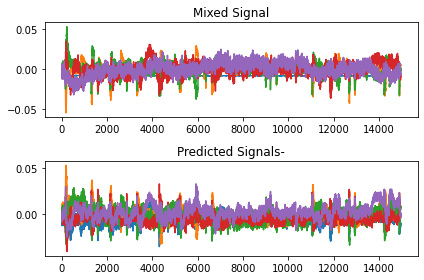

In [23]:
plot_results(U[:,:5].T, S[:5])

Plotting a graph of the five created individual components. 

Channel 1 :
 [-0.00947964 -0.01129001 -0.01276583 ... -0.01247751 -0.01378124
 -0.01438453]


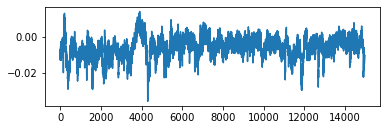

Channel 2 :
 [ 0.00183262  0.00045875 -0.00031902 ... -0.00158601 -0.00177093
 -0.00249848]


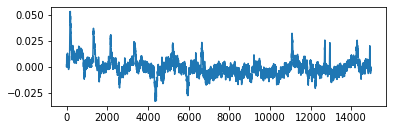

Channel 3 :
 [-0.00469628 -0.00440365 -0.00668455 ...  0.00827651  0.00737136
  0.00826765]


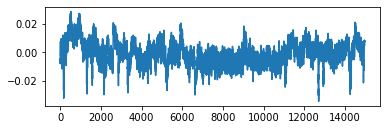

Channel 4 :
 [-4.39374438e-03 -2.60240914e-03 -7.71417587e-04 ... -2.60577067e-04
 -6.47565886e-05 -4.01742063e-04]


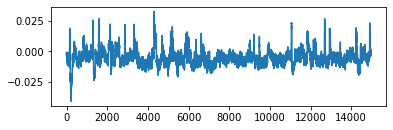

Channel 5 :
 [-0.00648458 -0.00707066 -0.00812584 ...  0.00077253 -0.00245536
 -0.0045102 ]


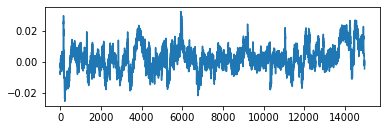

In [24]:
for i, s in enumerate(S[:5]):
    print("Channel", (i+1), ":\n", s)
    plt.subplot(2, 1, 2)
    plt.plot(s)
    plt.show()

Manually removing predicted blink channels by setting them to zero
Graphs #3 and 5 have peaks correlated with the timestamps of blinks, so we'll remove them to focus on relevant EEG data.

In [25]:
remove_indices = [2,4]
S[remove_indices, :] = 0

Channel 1 :
 [-0.00947964 -0.01129001 -0.01276583 ... -0.01247751 -0.01378124
 -0.01438453]


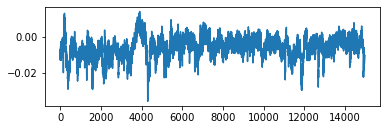

Channel 2 :
 [ 0.00183262  0.00045875 -0.00031902 ... -0.00158601 -0.00177093
 -0.00249848]


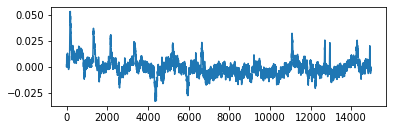

Channel 3 :
 [0. 0. 0. ... 0. 0. 0.]


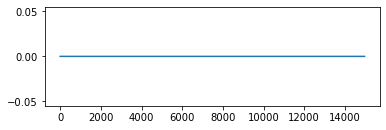

Channel 4 :
 [-4.39374438e-03 -2.60240914e-03 -7.71417587e-04 ... -2.60577067e-04
 -6.47565886e-05 -4.01742063e-04]


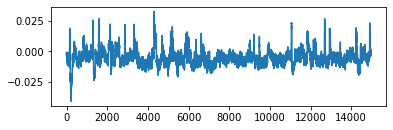

Channel 5 :
 [0. 0. 0. ... 0. 0. 0.]


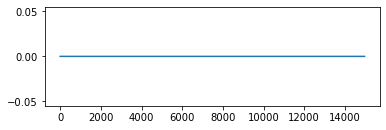

In [26]:
for i, s in enumerate(S):
    print("Channel", (i+1), ":\n", s)
    plt.subplot(2, 1, 2)
    plt.plot(s)
    plt.show()